# Deteccion de bots en plataformas de streaming

# 1. Preparar datos

In [9]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("=" * 40)
print("MODELADO DETECCIÓN DE BOTS")
print("=" * 40)
print("✅ Librerías importadas")

MODELADO DETECCIÓN DE BOTS
✅ Librerías importadas


# 2. Cargar dataset

In [87]:
# Cargar dataset
df = pd.read_csv('kick_chat_datasetV3.csv')

print(f"\n Dataset cargado: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"   Balance: {(df['is_bot']==0).sum()} humanos / {(df['is_bot']==1).sum()} bots")
print(f"   Proporción: {(df['is_bot']==0).mean()*100:.1f}% humanos")

# Verificar valores nulos
print(f"\n Valores nulos:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# %%
# Preparar features y target
print("\n" + "=" * 40)
print("PREPARACIÓN DE DATOS")
print("=" * 40)

# Features a utilizar (excluir identificadores y target)
features = [
    'frequency', 'avg_message_length', 'total_messages',
    'url_ratio', 'repetition_ratio', 'time_in_channel',
    'suspicious_links', 'generic_name',
    'username_length', 'has_numbers', 'has_underscore',
    'numeric_ratio', 'uppercase_ratio', 'special_char_count'
]

# Manejar valores nulos (si los hay)
df_clean = df[features + ['is_bot']].copy()
df_clean = df_clean.fillna(df_clean.mean())  # Rellenar con media

X = df_clean[features]
y = df_clean['is_bot']

print(f"\n Features seleccionadas: {len(features)}")
print(f"   {', '.join(features[:5])}...")
print(f"\n Distribución de clases:")
print(f"   Clase 0 (Humanos): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"   Clase 1 (Bots):    {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")



 Dataset cargado: 2357 filas × 17 columnas
   Balance: 1414 humanos / 943 bots
   Proporción: 60.0% humanos

 Valores nulos:
Series([], dtype: int64)

PREPARACIÓN DE DATOS

 Features seleccionadas: 14
   frequency, avg_message_length, total_messages, url_ratio, repetition_ratio...

 Distribución de clases:
   Clase 0 (Humanos): 1414 (60.0%)
   Clase 1 (Bots):    943 (40.0%)


# 3. Matriz de Correlación + Heatmap

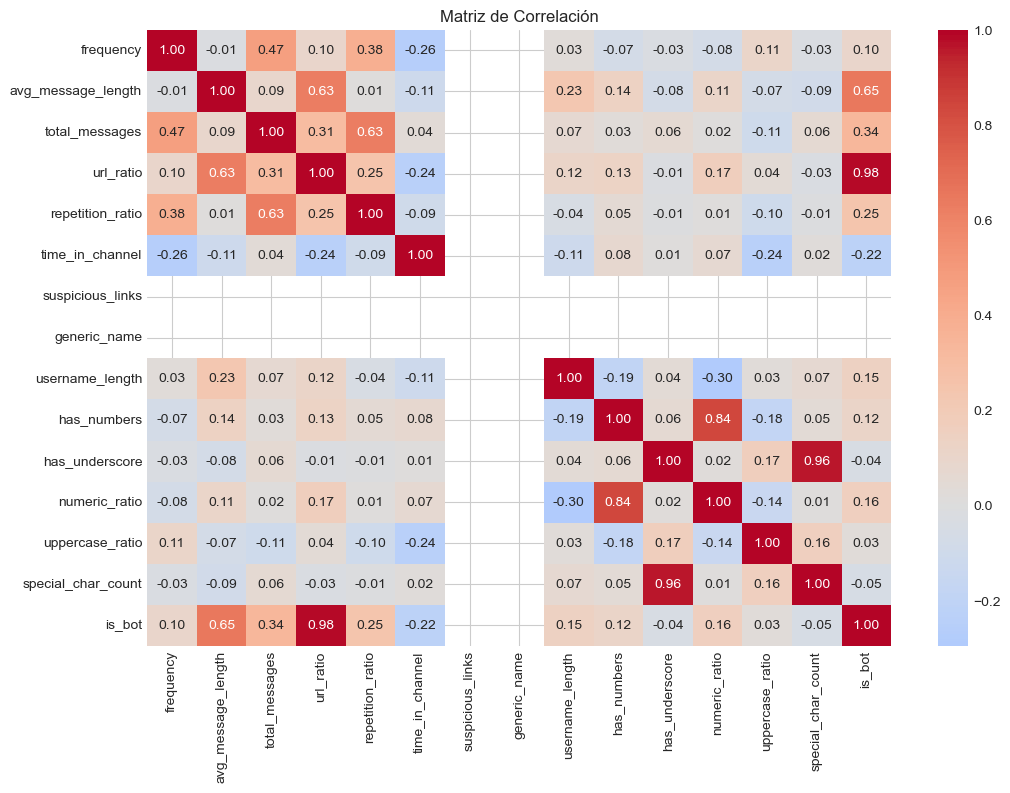

In [19]:
plt.figure(figsize=(12, 8))
corr = df[features + ['is_bot']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Matriz de Correlación")
plt.show()

# Split train/test estratificado

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n División train/test (80/20):")
print(f"   Train: {len(X_train)} instancias")
print(f"   Test:  {len(X_test)} instancias")
print(f"\n Balance en train:")
print(f"   Humanos: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"   Bots:    {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")


# Normalización (IMPORTANTE para KNN y Regresión Logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Normalización aplicada (StandardScaler)")
print(f"   Media después de escalar: {X_train_scaled.mean():.6f}")
print(f"   Desv. Est. después de escalar: {X_train_scaled.std():.6f}")


 División train/test (80/20):
   Train: 1885 instancias
   Test:  472 instancias

 Balance en train:
   Humanos: 1131 (60.0%)
   Bots:    754 (40.0%)

 Normalización aplicada (StandardScaler)
   Media después de escalar: -0.000000
   Desv. Est. después de escalar: 0.925820


# MODELO 1: REGRESIÓN LOGÍSTICA


MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)
=== REGRESIÓN LOGÍSTICA ===
              precision    recall  f1-score   support

      Humano       1.00      1.00      1.00       283
         Bot       0.99      1.00      1.00       189

    accuracy                           1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

ROC AUC: 0.9990

 FEATURE IMPORTANCE (Coeficientes):
           feature  coefficient
         url_ratio     5.201790
   username_length     0.473834
avg_message_length     0.426046
  repetition_ratio     0.404342
    total_messages     0.386244
     numeric_ratio     0.312169
   time_in_channel    -0.231740
special_char_count    -0.176514
    has_underscore    -0.171671
         frequency    -0.169196


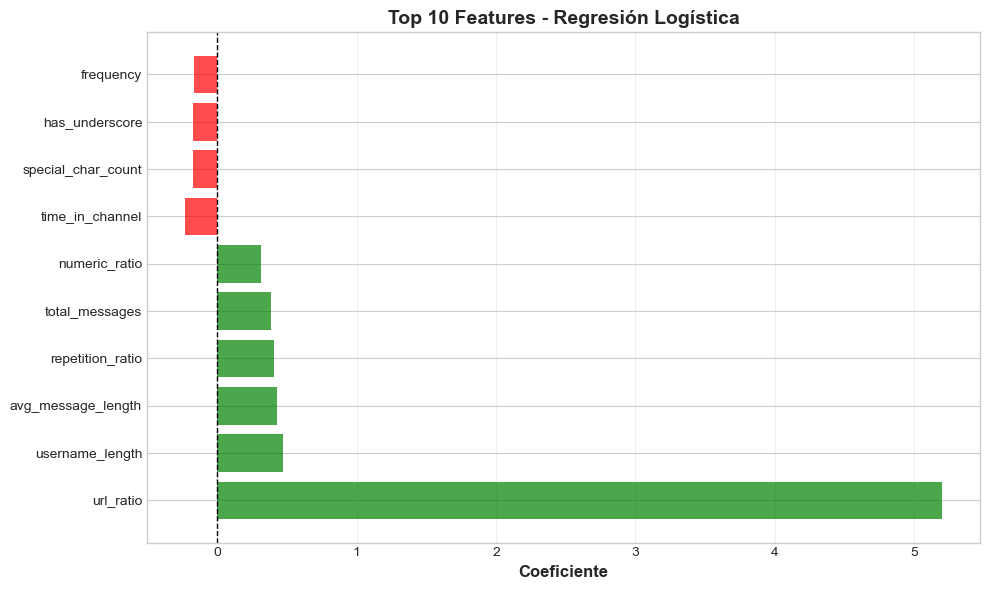

In [39]:

print("\n" + "=" * 40)
print("MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)")
print("=" * 40)

# Entrenar modelo base
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]


# Evaluación
print("=== REGRESIÓN LOGÍSTICA ===")
print(classification_report(y_test, y_pred_lr, target_names=['Humano', 'Bot']))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")


# Feature Importance (coeficientes)
print(f"\n FEATURE IMPORTANCE (Coeficientes):")
feature_importance_lr = pd.DataFrame({
    'feature': features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(feature_importance_lr.head(10).to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 6))
top_features = feature_importance_lr.head(10)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coeficiente', fontsize=12, fontweight='bold')
plt.title('Top 10 Features - Regresión Logística', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

# MODELO 2: K-NEAREST NEIGHBORS (KNN)

In [45]:

print("\n" + "=" * 40)
print("MODELO 2: K-NEAREST NEIGHBORS (KNN)")
print("=" * 40)

# Entrenar modelo base (k=5)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_knn = knn_model.predict(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("=== KNN (k=5) ===")
print(classification_report(y_test, y_pred_knn, target_names=['Humano', 'Bot']))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_knn):.4f}")



MODELO 2: K-NEAREST NEIGHBORS (KNN)
=== KNN (k=5) ===
              precision    recall  f1-score   support

      Humano       1.00      1.00      1.00       283
         Bot       0.99      1.00      1.00       189

    accuracy                           1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

ROC AUC: 1.0000


# MODELO 3: ÁRBOL DE DECISIÓN


MODELO 3: ÁRBOL DE DECISIÓN
=== ÁRBOL DE DECISIÓN ===
              precision    recall  f1-score   support

      Humano       1.00      1.00      1.00       283
         Bot       1.00      1.00      1.00       189

    accuracy                           1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

ROC AUC: 1.0000

 FEATURE IMPORTANCE:
           feature  importance
         url_ratio    0.993395
avg_message_length    0.006605
         frequency    0.000000
    total_messages    0.000000
  repetition_ratio    0.000000
   time_in_channel    0.000000
  suspicious_links    0.000000
      generic_name    0.000000
   username_length    0.000000
       has_numbers    0.000000


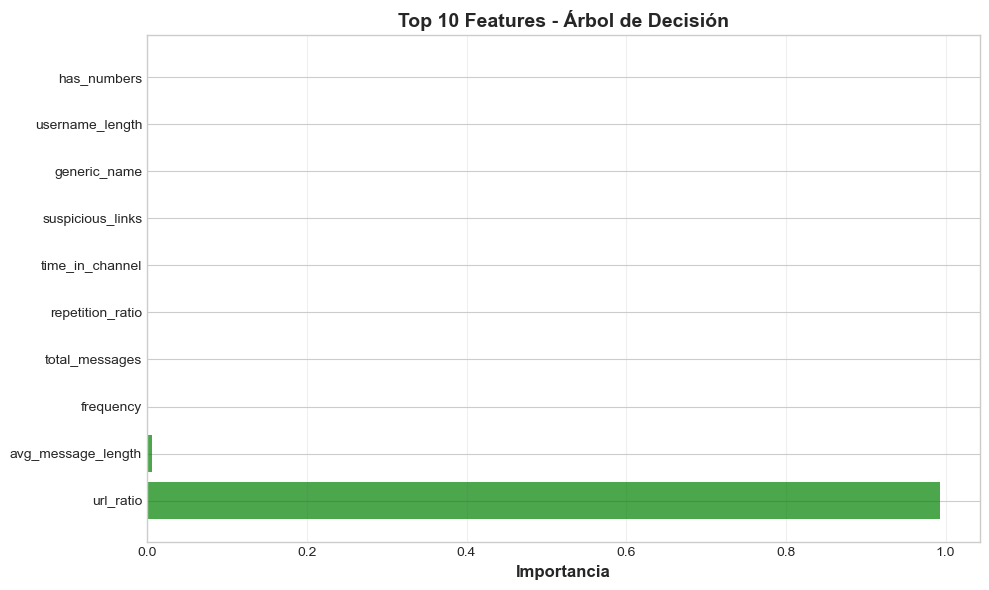

In [53]:
print("\n" + "=" * 40)
print("MODELO 3: ÁRBOL DE DECISIÓN")
print("=" * 40)

# Entrenar modelo base
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)  # No necesita normalización

# Predicciones
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:, 1]

# Evaluación
print("=== ÁRBOL DE DECISIÓN ===")
print(classification_report(y_test, y_pred_tree, target_names=['Humano', 'Bot']))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_tree):.4f}")


# Feature Importance
print(f"\n FEATURE IMPORTANCE:")
feature_importance_dt = pd.DataFrame({
    'feature': features,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_dt.head(10).to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 6))
top_features_dt = feature_importance_dt.head(10)
plt.barh(top_features_dt['feature'], top_features_dt['importance'], color='green', alpha=0.7)
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.title('Top 10 Features - Árbol de Decisión', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

#  Comparación de Modelos

In [77]:
print("\n" + "=" * 40)
print("COMPARACIÓN DE MODELOS")
print("=" * 40)

results = {
    "Regresión Logística": {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba_lr)
    },
    "KNN (k=5)": {
        'Accuracy': accuracy_score(y_test, y_pred_knn),
        'F1-Score': f1_score(y_test, y_pred_knn, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba_knn)
    },
    "Árbol de Decisión": {
        'Accuracy': accuracy_score(y_test, y_pred_tree),
        'F1-Score': f1_score(y_test, y_pred_tree, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba_tree)
    }
}
print("\n ======== TABLA COMPARATIVA: ========")
results_df = pd.DataFrame(results).T.round(4)
results_df = results_df.sort_values(by='F1-Score', ascending=False)
display(results_df)

# Identificar mejor modelo
best_model_name = results_df['F1-Score'].idxmax()
best_f1 = results_df.loc[best_model_name, 'F1-Score']

print(f"\n MEJOR MODELO (por F1-Score): {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")


COMPARACIÓN DE MODELOS

 ======== TABLA COMPARATIVA: ========


,Accuracy,F1-Score,ROC AUC
Árbol de Decisión,1.0000,1.0000,1.000
Regresión Logística,0.9979,0.9979,0.999
KNN (k=5),0.9979,0.9979,1.000



 MEJOR MODELO (por F1-Score): Árbol de Decisión
   F1-Score: 1.0000


# PCA

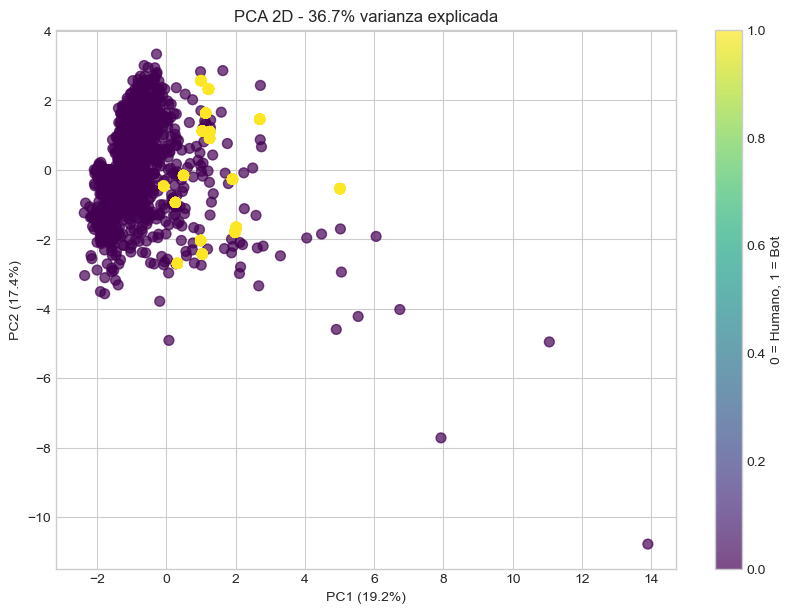

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_scaled = StandardScaler().fit_transform(df[features])
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['is_bot'], cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='0 = Humano, 1 = Bot')
plt.title(f'PCA 2D - {sum(pca.explained_variance_ratio_):.1%} varianza explicada')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.savefig("figures/pca_2d.png", dpi=300, bbox_inches='tight')
plt.show()
